### Import

In [0]:
!pip install sklearn_pandas
!pip install seaborn --upgrade

### Load modules

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn_pandas import DataFrameMapper, FunctionTransformer, CategoricalImputer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Data Cleaning

In [0]:
train_data = pd.read_csv("drive/My Drive/PyColab Work/FlightPricePredict/train.csv")
sub_data = pd.read_csv("drive/My Drive/PyColab Work/FlightPricePredict/test.csv")
#train_data.drop(index = 6474, inplace = True, axis = 0) # 5m flight time #change to 24hr 5m
train_data.iloc[6474, 7] = "24h 5m"
sub_data.iloc[2660, 7] = "24h 5m"

train_data.iloc[1478, 0] = "Jet Airways Business"
train_data.iloc[2618, 0] = "Jet Airways Business"
train_data.iloc[5439, 0] = "Jet Airways Business"

train_data.drop(index = 2924, inplace = True, axis = 0)
#train_data.drop(index = 5136, inplace = True, axis = 0)
#train_data.drop(index = 2618, inplace = True, axis = 0)
#train_data.drop(index = 5439, inplace = True, axis = 0)


# Date need to be looked at # Move this
train_data["Week"] = pd.to_datetime(train_data["Date_of_Journey"], dayfirst = True).dt.weekday_name
train_data["Month"] = pd.to_datetime(train_data["Date_of_Journey"], dayfirst = True).dt.month
train_data["Airline"] = train_data.Airline.replace("Trujet", "SpiceJet")
train_data["class"] = np.where(train_data['Airline']=='Jet Airways Business', 'High', 'Low')
train_data["meal"] = np.where(train_data['Additional_Info']=='In-flight meal not included', 'High', 'Low')
train_data["checkin"] = np.where(train_data['Additional_Info']=='No check-in baggage included', 'High', 'Low')
train_data["Destination"] = np.where(train_data["Destination"] == "New Delhi", "Delhi", train_data["Destination"])
train_data["Airline"] = np.where(train_data["Airline"] == "Vistara Premium economy", "Multiple carriers Premium economy", train_data["Airline"])
train_data["S1"], train_data["S2"], train_data['S3'], train_data["S4"], train_data['S5'], train_data["S6"] = train_data.Route.str.replace("?", "-").str.split(" - ").str

def temp_to_min(X):
    hour, minute = pd.Series(X).str.split(" ", 1).str
    hour = pd.Series(hour).str.replace("h", " ")
    hour = hour.astype('int64')
    minute = pd.Series(minute).str.replace("m", " ")
    minute = minute.fillna(0)
    minute = minute.astype('int64')
    total_minute = pd.to_timedelta( (hour * 60) + minute, unit = "m" )
    return(total_minute)

train_data['landing'] = pd.to_datetime(train_data['Date_of_Journey'] + '-' + train_data['Dep_Time'], dayfirst = True) + temp_to_min(train_data["Duration"])
train_data["Duration"] = temp_to_min(train_data["Duration"])
train_data["landingWeek"] = pd.to_datetime(train_data["landing"]).dt.weekday_name
train_data.drop(['Route'], axis = 1).head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,...,meal,checkin,S1,S2,S3,S4,S5,S6,landing,landingWeek
0,IndiGo,24/03/2019,Banglore,Delhi,22:20,01:10 22 Mar,02:50:00,non-stop,No info,3897,...,Low,Low,BLR,DEL,NaN,NaN,NaN,NaN,2019-03-25 01:10:00,Monday
1,Air India,1/05/2019,Kolkata,Banglore,05:50,13:15,07:25:00,2 stops,No info,7662,...,Low,Low,CCU,IXR,BBI,BLR,NaN,NaN,2019-05-01 13:15:00,Wednesday
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,04:25 10 Jun,19:00:00,2 stops,No info,13882,...,Low,Low,DEL,LKO,BOM,COK,NaN,NaN,2019-06-10 04:25:00,Monday
3,IndiGo,12/05/2019,Kolkata,Banglore,18:05,23:30,05:25:00,1 stop,No info,6218,...,Low,Low,CCU,NAG,BLR,NaN,NaN,NaN,2019-05-12 23:30:00,Sunday
4,IndiGo,01/03/2019,Banglore,Delhi,16:50,21:35,04:45:00,1 stop,No info,13302,...,Low,Low,BLR,NAG,DEL,NaN,NaN,NaN,2019-03-01 21:35:00,Friday


In [0]:
train_data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Week', 'Month', 'class', 'meal', 'checkin',
       'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'landing', 'landingWeek'],
      dtype='object')

### Bivariate

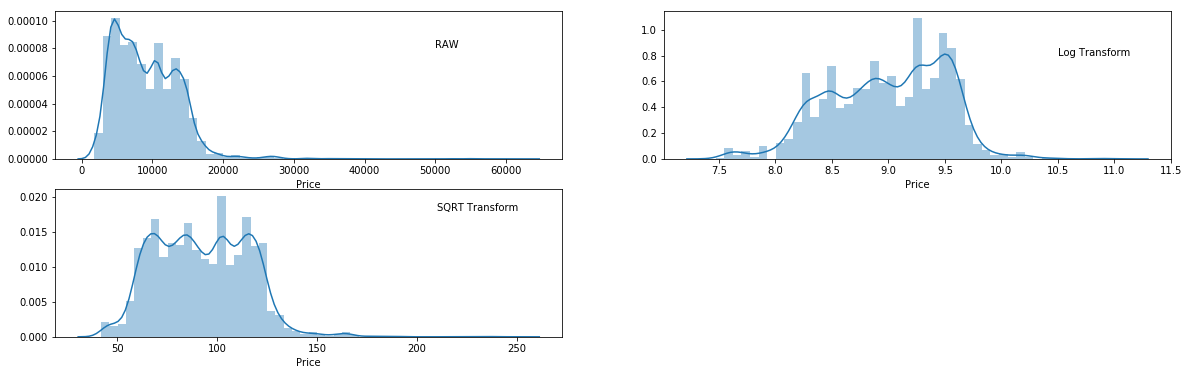

In [0]:
plt.figure(figsize=(20,6))
plt.subplot(2,2,1)
ax = sns.distplot(train_data.Price)
ax.text(50000, 0.00008, "RAW")
plt.subplot(2,2,2)
ax = sns.distplot(np.log(train_data.Price), )
ax.text(10.5, 0.8, "Log Transform")
plt.subplot(2,2,3)
ax = sns.distplot(np.sqrt(train_data.Price))
ax.text(210, 0.018, "SQRT Transform")
plt.show()

In [0]:
%%script false

train_data['Duration']

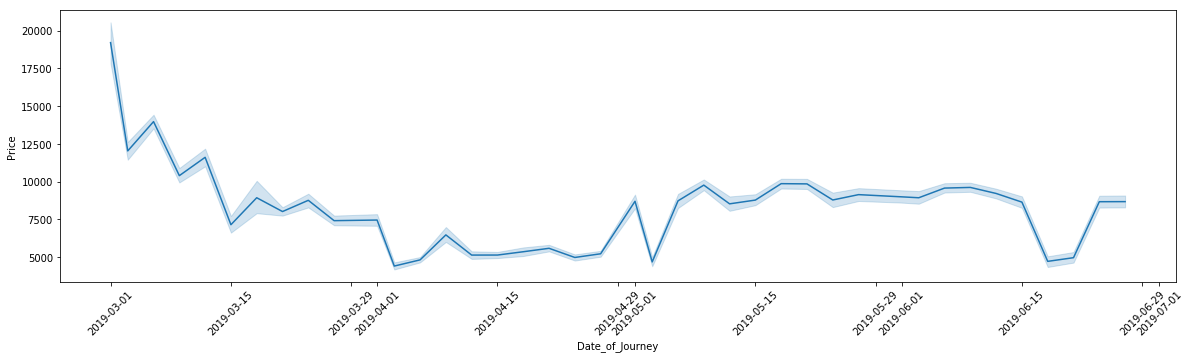

In [0]:
plt.figure(figsize=(20,5))
sns.lineplot(pd.to_datetime(train_data["Date_of_Journey"], dayfirst = True), train_data["Price"])
plt.xticks(rotation=45)
plt.show()

### Multivariate

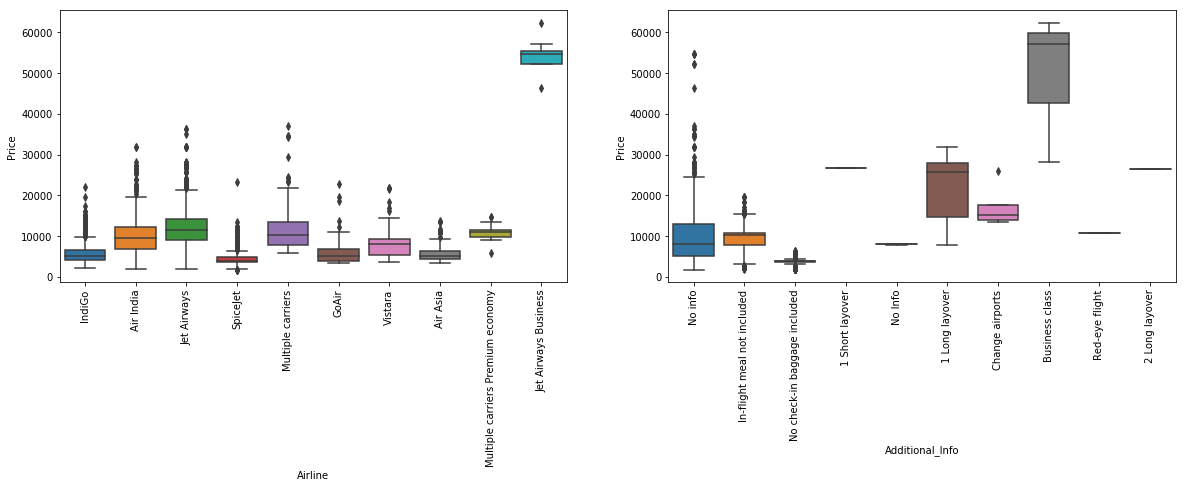

Jet Airways                          3846
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              819
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      16
Jet Airways Business                    8
Name: Airline, dtype: int64

In [0]:
#%%script false
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.boxplot(train_data['Airline'], train_data['Price'])
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.boxplot(train_data["Additional_Info"], train_data["Price"])
plt.xticks(rotation=90)
plt.show()
train_data.Airline.value_counts()

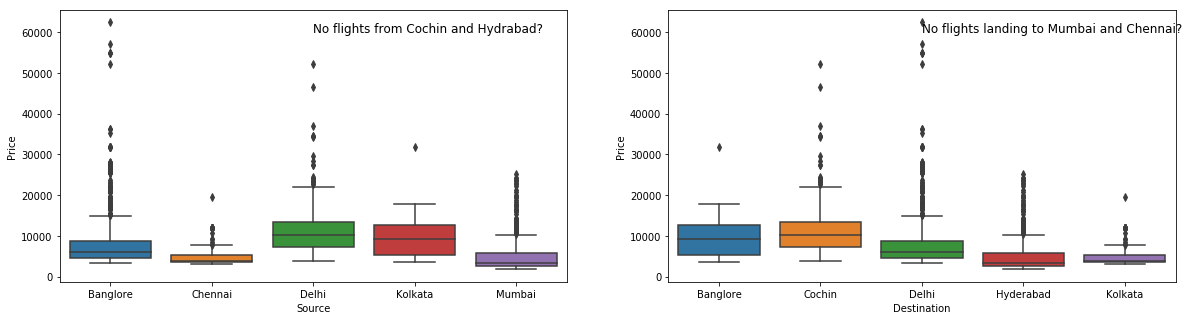

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
ax = sns.boxplot( train_data["Source"], train_data["Price"], order = np.unique(train_data["Source"]) )
ax.text(2, 60000,'No flights from Cochin and Hydrabad?', fontsize=12) 
plt.subplot(1, 2, 2)
ax = sns.boxplot( train_data["Destination"], train_data["Price"], order = np.unique(train_data["Destination"]) )
ax.text(2, 60000,'No flights landing to Mumbai and Chennai?', fontsize=12) 
plt.show()

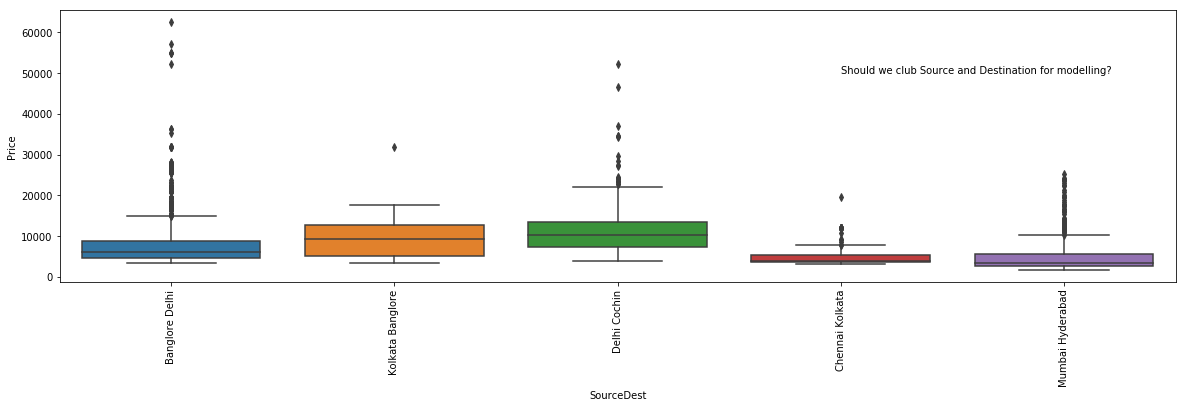

In [0]:
plt.figure(figsize=(20,5))
ax = sns.boxplot('SourceDest', 'Price', data = pd.DataFrame({ 'SourceDest' :train_data['Source'] + " " + train_data['Destination'], 'Price' :train_data['Price'] }))
ax.text(3, 50000, "Should we club Source and Destination for modelling?")
plt.xticks(rotation = 90)
plt.show()

In [0]:
pd.DataFrame({ 'a-SourceDest' :train_data['Source'] + " " + train_data['Destination'], 'c-Dur':train_data['Duration'] })